In [2]:
from math import sqrt
import numpy as np
from sklearn.preprocessing import MinMaxScaler,LabelEncoder,RobustScaler,StandardScaler
from sklearn.metrics import mean_squared_error
from datetime import datetime
from keras.layers import Input, Bidirectional,Dropout,LSTM,Dense,Embedding,Flatten,Reshape, BatchNormalization,LeakyReLU
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.models import Model,Sequential
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import time
import os
import seaborn as sn
import copy

In [3]:
df = pd.read_csv('./PCCA_Impute.csv')
df['Datetime']=pd.to_datetime(df['Datetime'])
df.set_index('Datetime',inplace=True)
df.head()

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM
Datetime,,,,,,,,,,,,
2013-03-01 00:00:00,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,0.0,4.4
2013-03-01 01:00:00,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,1.0,4.7
2013-03-01 02:00:00,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,0.0,5.6
2013-03-01 03:00:00,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,2.0,3.1
2013-03-01 04:00:00,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,1.0,2.0


In [4]:
df.describe()

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM
count,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.00000,35064.000000,35064.000000,35064.000000
mean,82.509824,109.866996,17.429875,59.311994,1262.945235,55.867345,13.584353,1011.846950,3.12326,0.067420,7.025896,1.708428
std,81.175828,94.293257,22.545238,36.636534,1190.100376,56.798629,11.395889,10.401083,13.68505,0.909796,4.471321,1.203851
min,3.000000,2.000000,0.285600,2.000000,100.000000,-43.969633,-16.800000,985.900000,-35.30000,0.000000,-1.000000,0.000000
25%,23.000000,39.000000,3.000000,31.000000,500.000000,9.000000,3.100000,1003.300000,-8.10000,0.000000,4.000000,0.900000
50%,60.000000,88.000000,9.000000,55.000000,900.000000,42.000000,14.500000,1011.400000,3.80000,0.000000,6.000000,1.400000
75%,113.000000,153.000000,22.000000,81.000000,1500.000000,81.000000,23.300000,1020.100000,15.60000,0.000000,10.000000,2.200000
max,898.000000,984.000000,341.000000,290.000000,10000.000000,423.000000,40.500000,1042.000000,28.50000,72.500000,15.000000,11.200000


In [5]:
# df['dow']=df.index.day_of_week
# df['doy']=df.index.day_of_year
# df['moy']=df.index.month
# df['hour']=df.index.hour
# df['year']=df.index.year
# df_train=df[(df['year']<2021) | (df['moy']<=5)]
# df_test=df[(df['year']>=2021) & (df['moy']>=5)]

In [6]:
# features_to_scale = ['PM2.5', 'PM10', 'NO2', 'NH3', 'SO2', 'CO', 'Ozone', 'Temp', 'RH','WS','WD']
features_to_scale = ['PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3', 'TEMP', 'PRES','RAIN','wd','WSPM']

def scaling(df,features_to_scale):
    scaler = RobustScaler()
    # scaler = MinMaxScaler()
    # scaler = StandardScaler()

    # Specify the features you want to scale

    # Fit the scaler to your data
    scaler.fit(df[features_to_scale])

    # Transform your data
    scaled_data = scaler.transform(df[features_to_scale])

    # Convert the scaled data array back to a DataFrame
    scaled_df = pd.DataFrame(scaled_data, columns=features_to_scale,index=df.index)

    # Now scaled_df contains the scaled values of your features using RobustScaler
    print(max(scaled_df['PM2.5']))
    print(min(scaled_df['PM2.5']))

    return scaled_df,scaler

In [7]:
df[features_to_scale],scaler=scaling(df,features_to_scale)
df['dow']=df.index.day_of_week
df['doy']=df.index.day_of_year
df['moy']=df.index.month
df['hour']=df.index.hour
df['year']=df.index.year
df

9.311111111111112
-0.6333333333333333


,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,dow,doy,moy,hour,year
Datetime,,,,,,,,,,,,,,,,,
2013-03-01 00:00:00,-0.622222,-0.736842,-0.263158,-0.96,-0.6,0.486111,-0.752475,0.690476,-18.8,0.0,-1.000000,2.307692,4,60,3,0,2013
2013-03-01 01:00:00,-0.577778,-0.701754,-0.263158,-0.96,-0.6,0.486111,-0.772277,0.702381,-18.2,0.0,-0.833333,2.538462,4,60,3,1,2013
2013-03-01 02:00:00,-0.588889,-0.710526,-0.210526,-0.90,-0.6,0.430556,-0.772277,0.720238,-18.2,0.0,-1.000000,3.230769,4,60,3,2,2013
2013-03-01 03:00:00,-0.600000,-0.719298,0.105263,-0.88,-0.6,0.416667,-0.787129,0.779762,-19.4,0.0,-0.666667,1.307692,4,60,3,3,2013
2013-03-01 04:00:00,-0.633333,-0.745614,0.157895,-0.86,-0.6,0.416667,-0.816832,0.821429,-19.5,0.0,-0.833333,0.461538,4,60,3,4,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-02-28 19:00:00,-0.533333,-0.517544,-0.210526,-0.40,-0.5,0.736111,-0.099010,0.125000,-16.2,0.0,-0.666667,0.769231,1,59,2,19,2017
2017-02-28 20:00:00,-0.522222,-0.447368,-0.105263,-0.20,-0.4,0.541667,-0.143564,0.130952,-15.1,0.0,0.833333,-0.384615,1,59,2,20,2017
2017-02-28 21:00:00,-0.488889,-0.447368,0.052632,0.22,-0.2,0.222222,-0.183168,0.166667,-13.3,0.0,-0.666667,-0.230769,1,59,2,21,2017


In [8]:
df.describe()

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,dow,doy,moy,hour,year
count,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.00000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000
mean,0.250109,0.191816,0.443678,0.086240,0.362945,0.192602,-0.045329,0.026604,3.12326,0.067420,0.170983,0.237253,3.000684,183.125257,6.522930,11.500000,2014.662560
std,0.901954,0.827134,1.186591,0.732731,1.190100,0.788870,0.564153,0.619112,13.68505,0.909796,0.745220,0.926039,2.001226,105.440146,3.448752,6.922285,1.177213
min,-0.633333,-0.754386,-0.458653,-1.060000,-0.800000,-1.194023,-1.549505,-1.517857,-35.30000,0.000000,-1.166667,-1.076923,0.000000,1.000000,1.000000,0.000000,2013.000000
25%,-0.411111,-0.429825,-0.315789,-0.480000,-0.400000,-0.458333,-0.564356,-0.482143,-8.10000,0.000000,-0.333333,-0.384615,1.000000,92.000000,4.000000,5.750000,2014.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.80000,0.000000,0.000000,0.000000,3.000000,183.000000,7.000000,11.500000,2015.000000
75%,0.588889,0.570175,0.684211,0.520000,0.600000,0.541667,0.435644,0.517857,15.60000,0.000000,0.666667,0.615385,5.000000,274.000000,10.000000,17.250000,2016.000000
max,9.311111,7.859649,17.473684,4.700000,9.100000,5.291667,1.287129,1.821429,28.50000,72.500000,1.500000,7.538462,6.000000,366.000000,12.000000,23.000000,2017.000000


In [9]:
df_train=df.head(28064)
df_test=df.tail(7000)

# Filter df_train to include only the last 14 values
last_14_values = df_train.tail(14)

# Append the last 14 values from df_train to df_test
df_test = pd.concat([last_14_values, df_test], axis=0)


In [10]:
df_train.drop(columns=['year'],inplace=True)
df_test.drop(columns=['year'],inplace=True)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_3676\2659423081.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(columns=['year'],inplace=True)


In [11]:
df_train

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,dow,doy,moy,hour
Datetime,,,,,,,,,,,,,,,,
2013-03-01 00:00:00,-0.622222,-0.736842,-0.263158,-0.96,-0.6,0.486111,-0.752475,0.690476,-18.8,0.0,-1.000000,2.307692,4,60,3,0
2013-03-01 01:00:00,-0.577778,-0.701754,-0.263158,-0.96,-0.6,0.486111,-0.772277,0.702381,-18.2,0.0,-0.833333,2.538462,4,60,3,1
2013-03-01 02:00:00,-0.588889,-0.710526,-0.210526,-0.90,-0.6,0.430556,-0.772277,0.720238,-18.2,0.0,-1.000000,3.230769,4,60,3,2
2013-03-01 03:00:00,-0.600000,-0.719298,0.105263,-0.88,-0.6,0.416667,-0.787129,0.779762,-19.4,0.0,-0.666667,1.307692,4,60,3,3
2013-03-01 04:00:00,-0.633333,-0.745614,0.157895,-0.86,-0.6,0.416667,-0.816832,0.821429,-19.5,0.0,-0.833333,0.461538,4,60,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-13 03:00:00,-0.366667,-0.535088,-0.368421,0.06,-0.4,-0.555556,-0.306931,0.261905,4.5,0.0,-0.333333,-0.076923,4,134,5,3
2016-05-13 04:00:00,-0.588889,-0.315789,-0.368421,-0.02,-0.4,0.158613,-0.336634,0.309524,5.0,0.0,0.333333,-0.846154,4,134,5,4
2016-05-13 05:00:00,-0.288889,-0.403509,-0.368421,-0.10,-0.4,-0.555556,-0.356436,0.345238,4.8,0.0,-0.500000,-0.769231,4,134,5,5


In [12]:
df_test

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,dow,doy,moy,hour
Datetime,,,,,,,,,,,,,,,,
2016-05-12 18:00:00,-0.555556,-0.631579,-0.315789,-0.84,-0.7,0.777778,0.336634,-0.029762,-5.6,0.0,-1.000000,1.923077,3,133,5,18
2016-05-12 19:00:00,-0.555556,-0.456140,-0.368421,-0.74,-0.6,0.652778,0.287129,0.017857,-5.6,0.0,-1.000000,0.615385,3,133,5,19
2016-05-12 20:00:00,-0.377778,-0.315789,-0.368421,-0.50,-0.5,0.333333,0.143564,0.071429,0.1,0.0,-1.000000,-0.615385,3,133,5,20
2016-05-12 21:00:00,-0.544444,-0.096491,-0.368421,-0.16,-0.4,-0.111111,0.009901,0.142857,1.6,0.0,1.500000,-0.692308,3,133,5,21
2016-05-12 22:00:00,-0.422222,0.333333,-0.315789,0.16,-0.1,-0.555556,-0.084158,0.178571,2.6,0.0,-1.166667,-1.076923,3,133,5,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-02-28 19:00:00,-0.533333,-0.517544,-0.210526,-0.40,-0.5,0.736111,-0.099010,0.125000,-16.2,0.0,-0.666667,0.769231,1,59,2,19
2017-02-28 20:00:00,-0.522222,-0.447368,-0.105263,-0.20,-0.4,0.541667,-0.143564,0.130952,-15.1,0.0,0.833333,-0.384615,1,59,2,20
2017-02-28 21:00:00,-0.488889,-0.447368,0.052632,0.22,-0.2,0.222222,-0.183168,0.166667,-13.3,0.0,-0.666667,-0.230769,1,59,2,21


In [13]:
columns=['PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3', 'TEMP', 'PRES','RAIN','wd','WSPM','dow','moy','hour']
# columns=['PM2.5','PM10','NO2','NH3','SO2','CO','TC','WC','dow','moy','hour']
# columns=['PM2.5','PM10','TC','WC','dow','moy','hour']
df_train_values=df_train[columns].values

trainX shape == (28040, 24, 14).
trainY shape == (28040, 1).
Epoch 1/15
1402/1402 [==============================] - 32s 21ms/step - loss: 0.1019 - val_loss: 0.1041
Epoch 2/15
1402/1402 [==============================] - 25s 18ms/step - loss: 0.0610 - val_loss: 0.0964
Epoch 3/15
1402/1402 [==============================] - 24s 17ms/step - loss: 0.0573 - val_loss: 0.1307
Epoch 4/15
1402/1402 [==============================] - 24s 17ms/step - loss: 0.0570 - val_loss: 0.1025
Epoch 5/15
1402/1402 [==============================] - 25s 18ms/step - loss: 0.0550 - val_loss: 0.0923
Epoch 6/15
1402/1402 [==============================] - 25s 18ms/step - loss: 0.0531 - val_loss: 0.0931
Epoch 7/15
1402/1402 [==============================] - 26s 18ms/step - loss: 0.0530 - val_loss: 0.0992
Epoch 8/15
1402/1402 [==============================] - 29s 21ms/step - loss: 0.0528 - val_loss: 0.0881
Epoch 9/15
1402/1402 [==============================] - 25s 18ms/step - loss: 0.0512 - val_loss: 0.0926
Epo

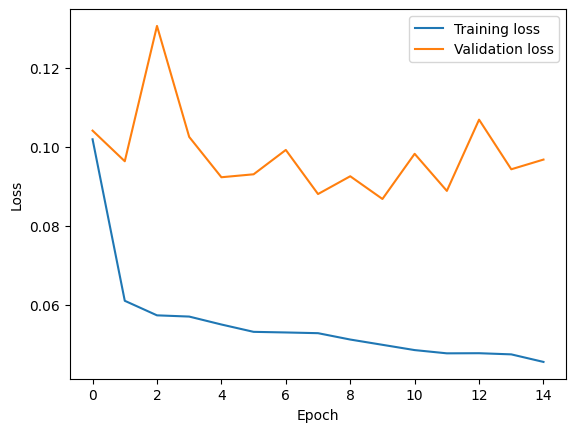

In [38]:
#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past hours.
n_past = 24  # Number of past hours we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_train_values has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_train_values) - n_future +1):
    trainX.append(df_train_values[i - n_past:i, 0:df_train.shape[1]])
    trainY.append(df_train_values[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

# Define the Autoencoder model
model = Sequential()

model.add(Bidirectional(LSTM(96, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences= False)))
model.add(LeakyReLU(0.7))
model.add(Dropout(0.2))
# model.add(LSTM(64, return_sequences=False))
# model.add(LeakyReLU(0.7))
# model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1],activation='linear'))
model.compile(optimizer='adam', loss='mse')

cp=ModelCheckpoint('models/model_epoch_{epoch:02d}.h5',save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# fit the model
history = model.fit(trainX, trainY, epochs=15, batch_size=16, validation_split=0.2, verbose=1,callbacks=[cp,early_stopping])

model.summary()

# Print final training and validation loss
print("Final training loss:", history.history['loss'][-1])
print("Final validation loss:", history.history['val_loss'][-1])

# Plot loss curves
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

testX shape == (6990, 24, 14).
testY shape == (6990, 1).
test shape == (1, 0, 14).
219/219 [==============================] - 2s 7ms/step
Mean Squared Error (MSE): 0.04765680301811402
Root Mean Squared Error (RMSE): 0.21830438158249144


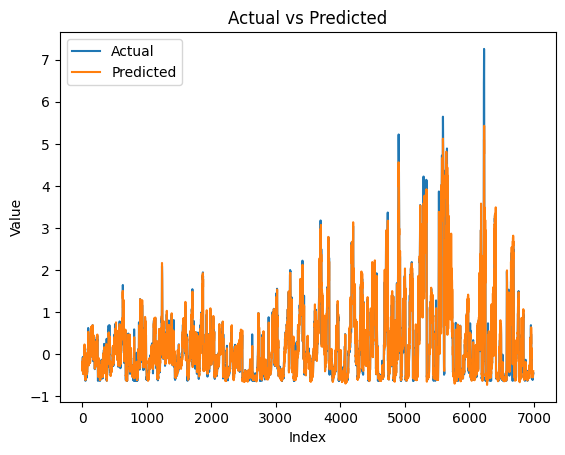

In [39]:
# model.load_weights('./Best_Models/2.h5')

# Extract the values from the test dataset
df_test_values = df_test[columns].values

# Similar to the training data, prepare the test data in the required shape
testX = []
testY = []

# Use the same parameters as used for training
for i in range(n_past, len(df_test_values) - n_future + 1):
    testX.append(df_test_values[i - n_past:i, 0:df_test.shape[1]])
    testY.append(df_test_values[i + n_future - 1:i + n_future, 0])

testX, testY = np.array(testX), np.array(testY)

print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))

test=[]
test.append(df_test_values[14- n_past:14, 0:df_test.shape[1]])
test=np.array(test)
print('test shape == {}.'.format(test.shape))

# Make predictions on the test data
predictions = model.predict(testX)

# Flatten the predictions and actual values arrays
# predictions = predictions.flatten()
# actual_values = testY.flatten()
actual_values= testY

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(actual_values, predictions)
print('Mean Squared Error (MSE):', mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = sqrt(mse)
print('Root Mean Squared Error (RMSE):', rmse)

# Plot actual vs predicted values
plt.plot(actual_values, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

(6990, 11)
Mean Squared Error (MSE): 386.0201007717517
Root Mean Squared Error (RMSE): 19.64739424890109


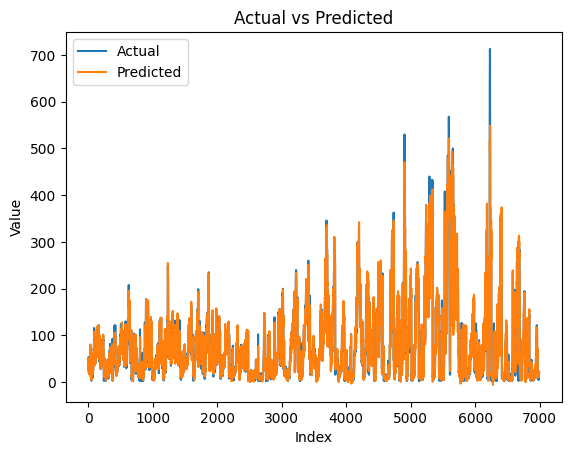

In [40]:
predictions= np.repeat(predictions, 11, axis=-1)
actual_values=np.repeat(actual_values, 11, axis=-1)

print(predictions.shape)

predictions = scaler.inverse_transform(predictions)[:,0]
actual_values= scaler.inverse_transform(actual_values)[:,0]

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(actual_values, predictions)
print('Mean Squared Error (MSE):', mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = sqrt(mse)
print('Root Mean Squared Error (RMSE):', rmse)

# Plot actual vs predicted values
plt.plot(actual_values, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

In [25]:
# model.save('./Best_Models/1.h5') RMSE-20.26

# columns=['PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3', 'TEMP', 'PRES','RAIN','wd','WSPM','dow','moy','hour']

# # Define the Autoencoder model
# model = Sequential()

# model.add(Bidirectional(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True)))
# model.add(LeakyReLU(0.15))
# model.add(Dropout(0.2))
# model.add(LSTM(64, return_sequences=False))
# model.add(LeakyReLU(0.15))
# model.add(Dropout(0.2))
# model.add(Dense(trainY.shape[1],activation='linear'))
# model.compile(optimizer='adam', loss='mse')

In [26]:
# model.save('./Best_Models/2.h5') # RMSE-19.93

# columns=['PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3', 'TEMP', 'PRES','RAIN','wd','WSPM','dow','moy','hour']

# # Define the Autoencoder model
# model = Sequential()

# model.add(Bidirectional(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True)))
# model.add(LeakyReLU(0.3))
# model.add(Dropout(0.2))
# model.add(LSTM(64, return_sequences=False))
# model.add(LeakyReLU(0.3))
# model.add(Dropout(0.2))
# model.add(Dense(trainY.shape[1],activation='linear'))
# model.compile(optimizer='adam', loss='mse')

In [19]:
# model.save('./Best_Models/3.h5') # RMSE-19.48

# columns=['PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3', 'TEMP', 'PRES','RAIN','wd','WSPM','dow','moy','hour']

# # Define the Autoencoder model
# model = Sequential()

# model.add(Bidirectional(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True)))
# model.add(LeakyReLU(0.6))
# model.add(Dropout(0.2))
# model.add(LSTM(64, return_sequences=False))
# model.add(LeakyReLU(0.6))
# model.add(Dense(trainY.shape[1],activation='linear'))
# model.compile(optimizer='adam', loss='mse')
